In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import random

sys.path.append("..")

print("Notebook Ready. Device:", "cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"

Notebook Ready. Device: cuda


In [2]:
from src.models.resnet50_multilabel import ResNet50Attr

CKPT_FE = "../outputs/checkpoints/resnet50_feature_extraction2.pth"
CKPT_FT = "../outputs/checkpoints/resnet50_finetune2.pth"

model_fe = ResNet50Attr(18).to(device)
model_ft = ResNet50Attr(18).to(device)

model_fe.load_state_dict(torch.load(CKPT_FE, map_location=device))
model_ft.load_state_dict(torch.load(CKPT_FT, map_location=device))

model_fe.eval()
model_ft.eval()

print("모델 로드 완료")

모델 로드 완료


In [3]:
from torch.utils.data import DataLoader
from src.data.dataset import DeepFashionAttrDataset
from src.data.preprocess import val_transform

VAL_CSV = "../data/processed/val.csv"
IMAGE_ROOT = "../data/raw/images"

val_ds = DeepFashionAttrDataset(VAL_CSV, IMAGE_ROOT, val_transform)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

print("Val Samples:", len(val_ds))

[Dataset Loaded]
- shape cols: 12
- fabric cols: 3
- pattern cols: 3
- total labels: 18
Val Samples: 4410


/tmp/ipykernel_1016014/3179695729.py:5: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  add_safe_globals([np.core.multiarray.scalar])


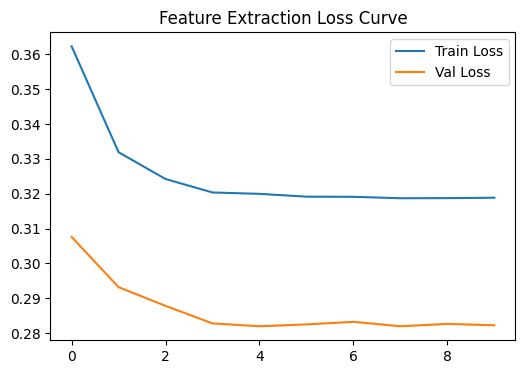

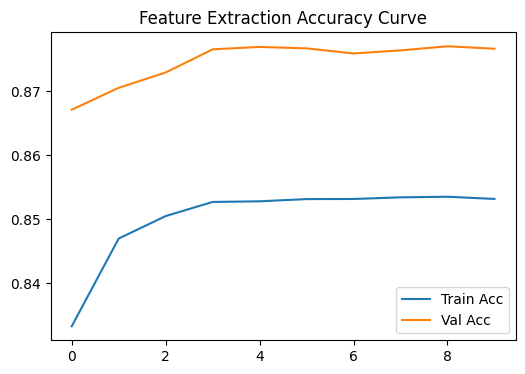

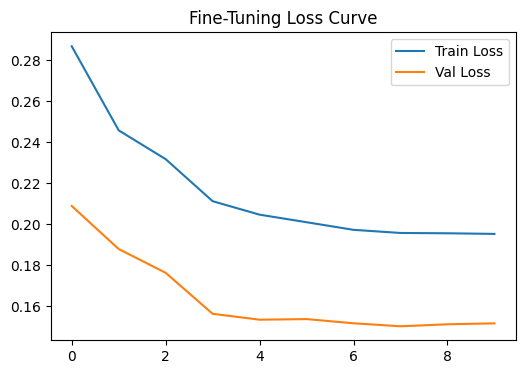

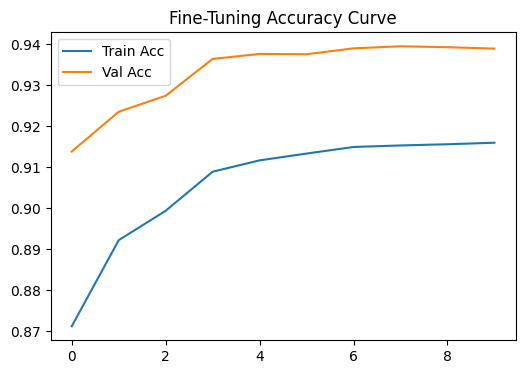

In [4]:
# 학습 히스토리
from torch.serialization import add_safe_globals

# numpy scalar 에러 방지
add_safe_globals([np.core.multiarray.scalar])

def _find_logs_dir():
    path = Path.cwd()
    for candidate in (path,) + tuple(path.parents):
        logs_dir = candidate / "outputs" / "logs"
        if logs_dir.exists():
            return logs_dir
    raise FileNotFoundError("outputs/logs 디렉토리를 찾을 수 없습니다.")

def load_history(filename: str):
    return torch.load(_find_logs_dir() / filename, map_location="cpu", weights_only=False)

def plot_history(history, title_prefix=""):
    plt.figure(figsize=(6,4))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title(f"{title_prefix} Loss Curve")
    plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title(f"{title_prefix} Accuracy Curve")
    plt.legend(); plt.show()

# Feature Extraction
plot_history(load_history("resnet50_feature_history2.pt"), title_prefix="Feature Extraction")

# Fine-Tuning
plot_history(load_history("resnet50_finetune_history2.pt"), title_prefix="Fine-Tuning")

In [5]:
# Train/Validation Accuracy & Loss Curve
def get_predictions(model, loader):
    all_probs, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.numpy())

    return np.concatenate(all_probs), np.concatenate(all_labels)

probs_fe, labels = get_predictions(model_fe, val_loader)
probs_ft, _      = get_predictions(model_ft, val_loader)

In [6]:
from src.models.metrics import compute_metrics

# 기본 Accuracy / Macro F1
acc_fe, f1_fe, _ = compute_metrics(labels, probs_fe)
acc_ft, f1_ft, _ = compute_metrics(labels, probs_ft)

print("===== Feature Extraction =====")
print("Accuracy:", acc_fe)
print("Macro F1:", f1_fe)

print("\n===== Fine-Tuning =====")
print("Accuracy:", acc_ft)
print("Macro F1:", f1_ft)

# Multi-label Accuracy
def multi_label_accuracy(true_labels, probs, threshold=0.5):
    preds = (probs >= threshold).astype(int)
    trues = true_labels.astype(int)
    per_sample_acc = (preds == trues).mean(axis=1)
    return per_sample_acc.mean()

ml_acc_fe = multi_label_accuracy(labels, probs_fe)
ml_acc_ft = multi_label_accuracy(labels, probs_ft)

print(f"\nFeature Extraction Multi-label Accuracy: {ml_acc_fe:.4f}")
print(f"Fine-Tuning Multi-label Accuracy:       {ml_acc_ft:.4f}")


===== Feature Extraction =====
Accuracy: 0.8766691861929957
Macro F1: 0.8571204256298708

===== Fine-Tuning =====
Accuracy: 0.9388888888888889
Macro F1: 0.929492027341912

Feature Extraction Multi-label Accuracy: 0.8767
Fine-Tuning Multi-label Accuracy:       0.9389


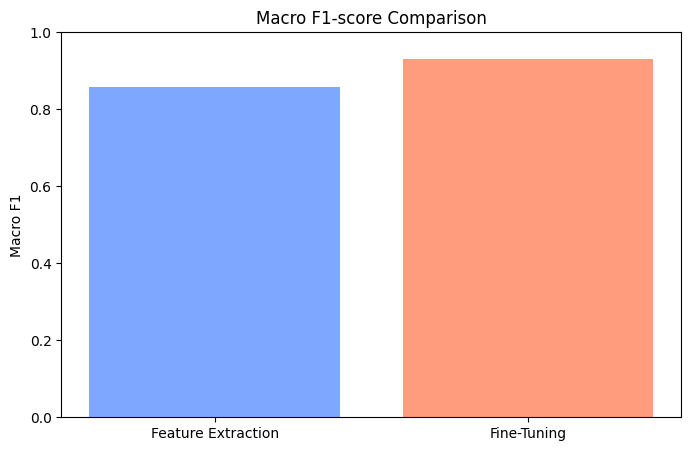

In [7]:
# Macro F1
plt.figure(figsize=(8,5))
plt.bar(["Feature Extraction", "Fine-Tuning"], [f1_fe, f1_ft],
        color=["#7EA8FF", "#FF9C7E"])
plt.title("Macro F1-score Comparison")
plt.ylabel("Macro F1")
plt.ylim(0, 1)
plt.show()

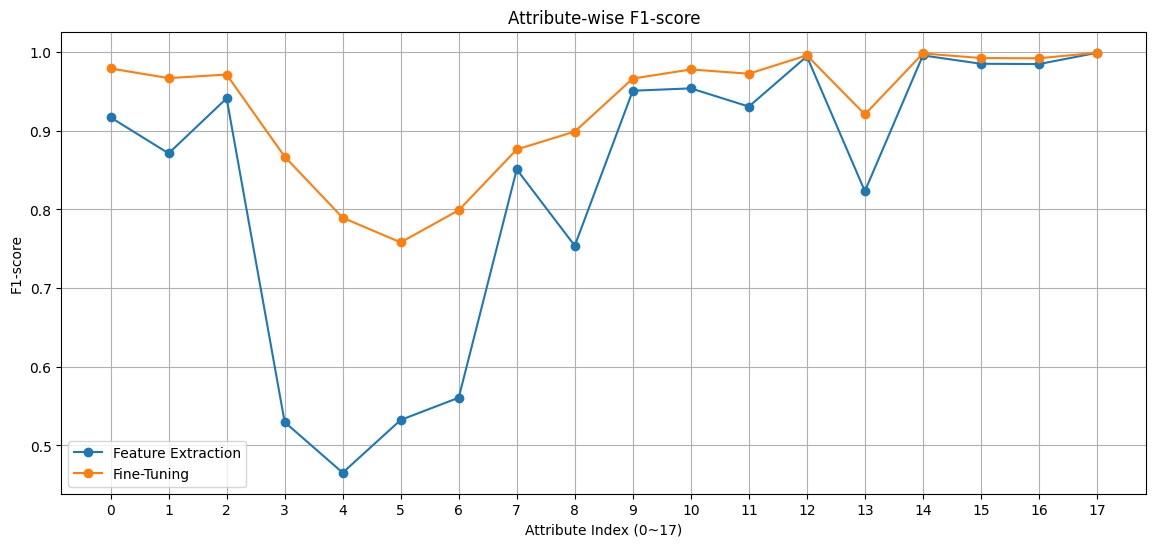

In [12]:
# Attribute-wise F1-score
_, _, attr_f1_fe = compute_metrics(labels, probs_fe)
_, _, attr_f1_ft = compute_metrics(labels, probs_ft)

plt.figure(figsize=(14,6))
plt.plot(attr_f1_fe, label="Feature Extraction", marker="o")
plt.plot(attr_f1_ft, label="Fine-Tuning", marker="o")
plt.title("Attribute-wise F1-score")
plt.xlabel("Attribute Index (0~17)")
plt.ylabel("F1-score")
plt.xticks(range(18))
plt.legend()
plt.grid(True)
plt.show()

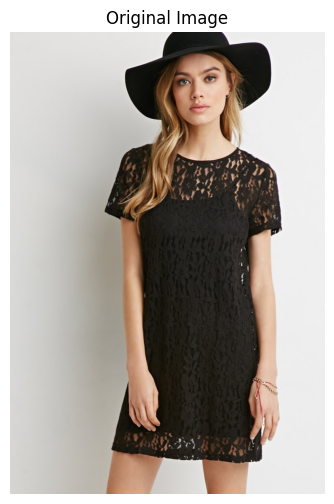

Image: WOMEN-Dresses-id_00001639-06_1_front.jpg
True Labels: [1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Feature Extraction Pred: [1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1]
Fine-Tuning Pred: [1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1]


In [9]:
# 예시 이미지에서 두 모델 예측 비교
idx = random.randint(0, len(val_ds)-1)
img, true_label = val_ds[idx]

img_path = os.path.join(IMAGE_ROOT, val_ds.df.iloc[idx]["image_name"])
original = Image.open(img_path)

with torch.no_grad():
    fe_pred = torch.sigmoid(model_fe(img.unsqueeze(0).to(device))).cpu().numpy()[0]
    ft_pred = torch.sigmoid(model_ft(img.unsqueeze(0).to(device))).cpu().numpy()[0]

plt.figure(figsize=(6,6))
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")
plt.show()

print("Image:", val_ds.df.iloc[idx]["image_name"])
print("True Labels:", true_label.numpy())
print("Feature Extraction Pred:", (fe_pred >= 0.5).astype(int))
print("Fine-Tuning Pred:", (ft_pred >= 0.5).astype(int))
